# Final position in variable interval


## Dependencies


The dependencies used are as follows


In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer

import sys

sys.path.append("..")

from utils.visualization import model_tuning
from utils.custom_cvs import VariableTimeSeriesSplit
from utils.custom_scorers import balanced_accuracy_1interval_score

import pandas as pd

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import warnings

warnings.simplefilter("ignore")

## Initialization


First we will do the tuning of the model that predicts the final position of each driver at a ±1 interval.


In [2]:
df = pd.read_csv("../assets/data/processed/base_model.csv")

mid_rc = df.groupby("raceYear")["raceRound"].max().to_numpy() // 2
get_half = lambda x: f'{x["raceYear"]}{x["raceRound"] <= mid_rc[x["raceYear"] - 2006]}'
instances_per_half = df.apply(get_half, axis=1).value_counts(sort=False).to_numpy()

n_splits = len(instances_per_half) - 10
max_train_size = [instances_per_half[i : 10 + i].sum() for i in range(n_splits)]
test_size = instances_per_half[10:].tolist()
tscv = VariableTimeSeriesSplit(
    n_splits=n_splits, max_train_size=max_train_size, test_size=test_size
)

X = pd.read_csv("../assets/data/processed/base_model_X.csv")
y = df["positionFinal"]

## K-Nearest Neighbors


KNeighborsClassifier: 0.348 with {'n_neighbors': 100, 'metric': 'manhattan', 'weights':
	'uniform'}


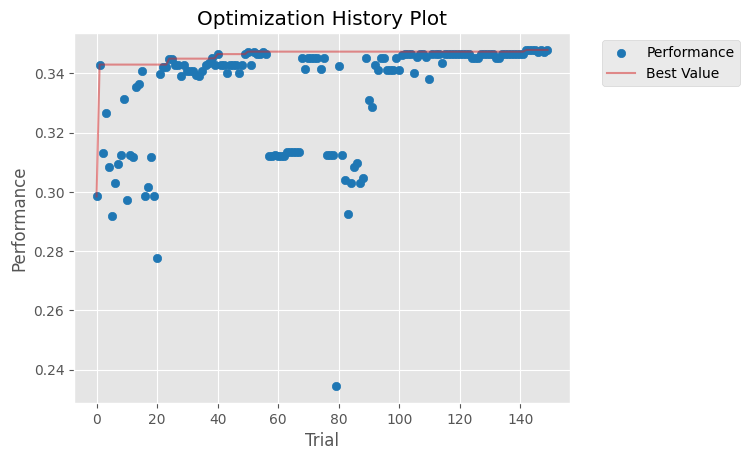

In [3]:
X_selected = X[
    [
        "positionGrid",
        "constructorRef",
        "driverWins",
    ]
]
params = [
    ("int", ("n_neighbors", 1, 101)),
    ("categorical", ("metric", ["cosine", "euclidean", "manhattan"])),
    ("categorical", ("weights", ["distance", "uniform"])),
]
model = KNeighborsClassifier
scoring = make_scorer(balanced_accuracy_1interval_score)
model_tuning(params, model, X_selected, y, tscv, scoring)

## Decision Tree


DecisionTreeClassifier: 0.349 with {'max_depth': 4, 'criterion': 'log_loss', 'splitter':
	'best'}


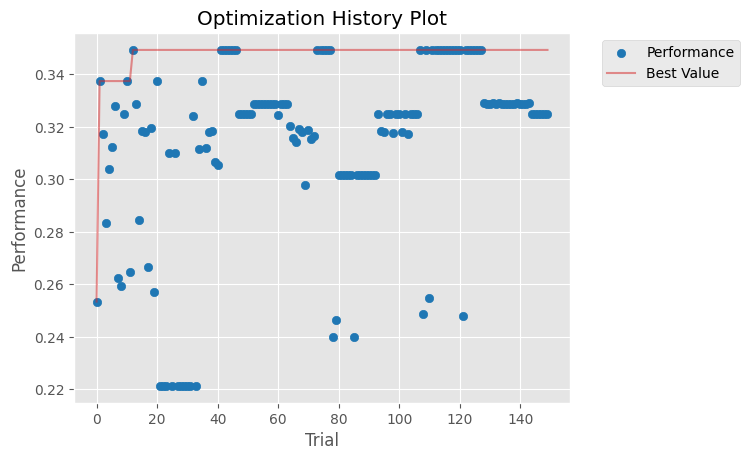

In [4]:
X_selected = X[
    [
        "carNumber",
        "positionGrid",
        "driverNationality",
        "constructorNationality",
        "raceYear",
        "raceRound",
        "grandPrix",
        "raceTime",
        "circuitRef",
        "circuitLocation",
        "circuitLng",
        "circuitAlt",
        "constructorWins",
        "q1",
        "q2",
        "q3",
        "driverAgeToday",
    ]
]
params = [
    ("int", ("max_depth", 1, 15)),
    ("categorical", ("criterion", ["gini", "log_loss", "entropy"])),
    ("categorical", ("splitter", ["best", "random"])),
]
model = DecisionTreeClassifier
scoring = make_scorer(balanced_accuracy_1interval_score)
model_tuning(params, model, X_selected, y, tscv, scoring)

## Random Forest


RandomForestClassifier: 0.363 with {'max_depth': 5, 'n_estimators': 432, 'criterion':
	'log_loss'}


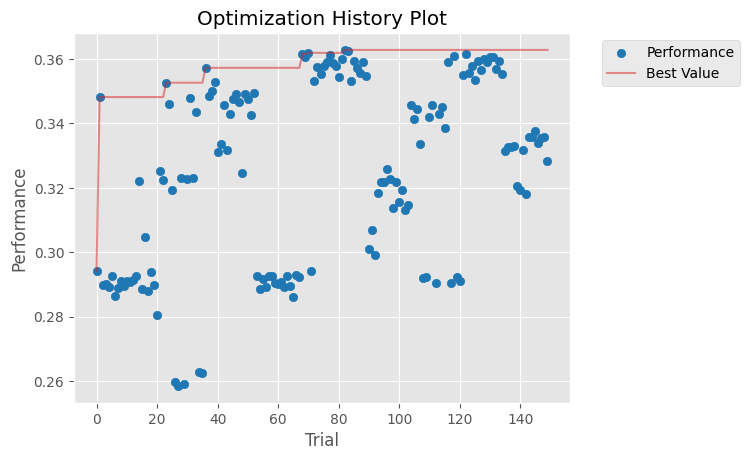

In [5]:
X_selected = X[
    [
        "carNumber",
        "positionGrid",
        "driverRef",
        "constructorNationality",
        "raceRound",
        "driverWins",
    ]
]
params = [
    ("int", ("max_depth", 1, 50)),
    ("int", ("n_estimators", 1, 500)),
    ("categorical", ("criterion", ["gini", "log_loss", "entropy"])),
]
model = RandomForestClassifier
scoring = make_scorer(balanced_accuracy_1interval_score)
model_tuning(params, model, X_selected, y, tscv, scoring)

## Multilayer Perceptron


MLPClassifier: 0.358 with {'activation': 'logistic', 'n_layers': 3, 'n_units_0': 46,
	'n_units_1': 27, 'n_units_2': 24}


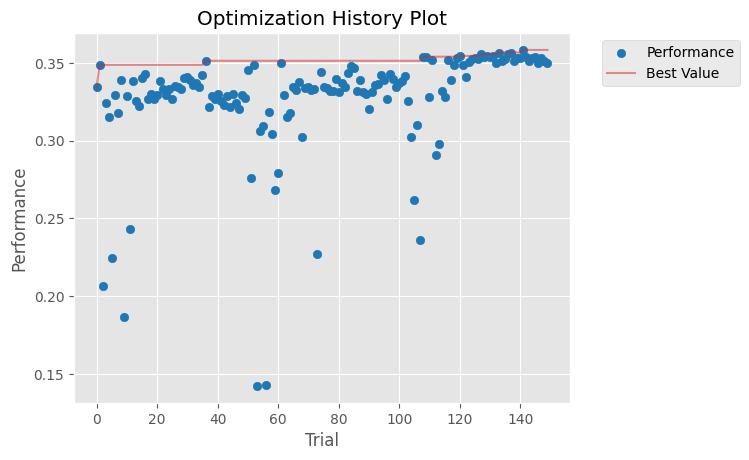

In [6]:
X_selected = X[
    [
        "positionGrid",
        "driverRef",
        "driverNumber",
        "constructorRef",
        "raceRound",
        "circuitCountry",
        "circuitAlt",
        "driverWins",
        "constructorWins",
        "driverAgeToday",
    ]
]
params = [
    ("categorical", ("activation", ["tanh", "logistic", "identity", "relu"])),
    ("mlp", ("hidden_layer_sizes", 4, 50)),
]
model = MLPClassifier
scoring = make_scorer(balanced_accuracy_1interval_score)
model_tuning(params, model, X_selected, y, tscv, scoring)

## Results


Therefore, the tuning for each algorithm are as follows

- KNeighborsClassifier: 0.348 with {'n_neighbors': 100, 'metric': 'manhattan', 'weights': 'uniform'}
- DecisionTreeClassifier: 0.349 with {'max_depth': 4, 'criterion': 'log_loss', 'splitter': 'best'}
- RandomForestClassifier: 0.363 with {'max_depth': 5, 'n_estimators': 432, 'criterion': 'log_loss'}
- MLPClassifier: 0.358 with {'activation': 'logistic', 'n_layers': 3, 'n_units_0': 46, 'n_units_1': 27, 'n_units_2': 24}
